In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest


In [2]:
df = pd.read_csv("Uber_Customer_Support_Tickets_Prepared.csv")
print(df.shape)     # rows, columns
print(df.columns)   # column names
df.head()           # view first 5 rows

(999, 15)
Index(['Ticket_ID', 'Created_At', 'Channel', 'Response_Time_Minutes',
       'Resolution_Time_Minutes', 'CSAT_Score', 'Issue_Type', 'Day', 'Month',
       'Weekday', 'Daily_Ticket_Count', 'Channel_Code', 'Issue_Code',
       'Resolution_Category', 'CSAT_Binary'],
      dtype='object')


,Ticket_ID,Created_At,Channel,Response_Time_Minutes,Resolution_Time_Minutes,CSAT_Score,Issue_Type,Day,Month,Weekday,Daily_Ticket_Count,Channel_Code,Issue_Code,Resolution_Category,CSAT_Binary
0,T0001,21-02-2025,Live Agent,4,175,3,Ride Cancellation,21,2,Friday,13,1,5,Slow,0
1,T0002,15-01-2025,Live Agent,7,15,4,Lost Item,15,1,Wednesday,11,1,3,Fast,1
2,T0003,13-03-2025,Live Agent,8,162,4,Account Access,13,3,Thursday,9,1,0,Slow,1
3,T0004,02-03-2025,Live Agent,17,154,2,Lost Item,2,3,Sunday,12,1,3,Slow,0
4,T0005,21-01-2025,Chatbot,5,70,5,Lost Item,21,1,Tuesday,11,0,3,Slow,1


DATA SPLIT IN 2 GROUPS

In [3]:
chatbot_scores = df[df["Channel"] == "Chatbot"]["CSAT_Score"].dropna()
agent_scores   = df[df["Channel"] == "Live Agent"]["CSAT_Score"].dropna()

chatbot_bin = df[df["Channel"] == "Chatbot"]["CSAT_Binary"].dropna()
agent_bin   = df[df["Channel"] == "Live Agent"]["CSAT_Binary"].dropna()

print(len(chatbot_scores), len(agent_scores))


604 394


In [4]:
#summary
def summary(series):
    return series.count(), series.mean(), series.std(), series.median(), series.min(), series.max()

print("Chatbot:", summary(chatbot_scores))
print("Agent:  ", summary(agent_scores))


Chatbot: (np.int64(604), np.float64(3.693708609271523), 1.1005321287269438, 4.0, 1, 5)
Agent:   (np.int64(394), np.float64(3.6776649746192893), 1.046092270117514, 4.0, 1, 5)


In [5]:
#plot

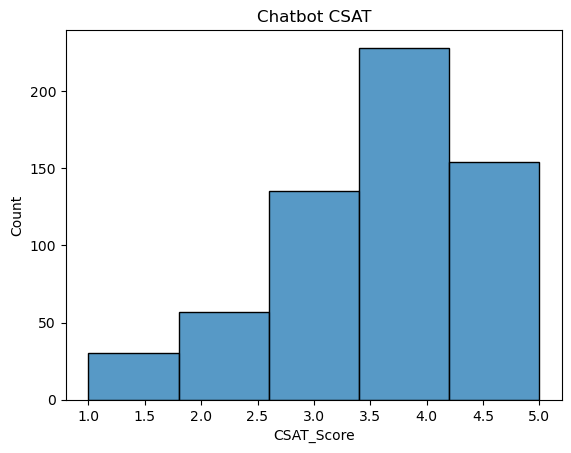

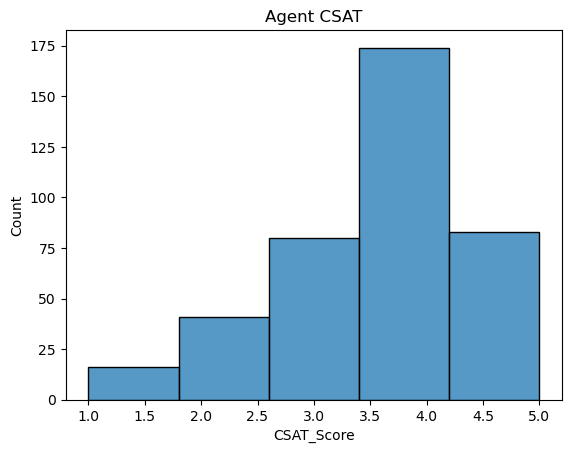

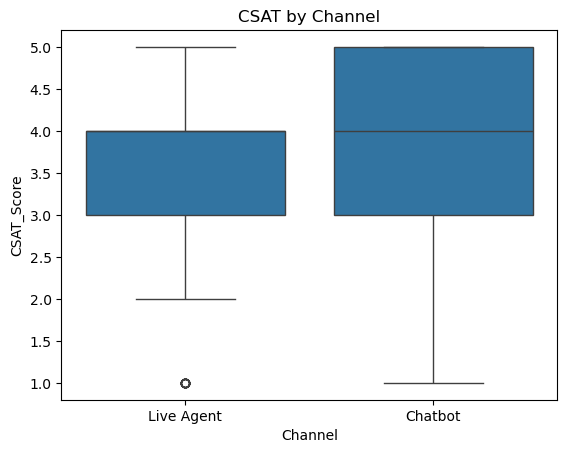

In [6]:
sns.histplot(chatbot_scores, bins=5).set(title="Chatbot CSAT")
plt.show()

sns.histplot(agent_scores, bins=5).set(title="Agent CSAT")
plt.show()

sns.boxplot(x="Channel", y="CSAT_Score", data=df[df["Channel"].isin(["Chatbot","Live Agent"])])
plt.title("CSAT by Channel")
plt.show()


In [7]:
# For large groups, test on a sample because Shapiro is slow
samp_chat = chatbot_scores.sample(n=min(500,len(chatbot_scores)), random_state=1)
samp_agent = agent_scores.sample(n=min(500,len(agent_scores)), random_state=1)

print("Shapiro Chatbot p:", stats.shapiro(samp_chat)[1])
print("Shapiro Agent  p:", stats.shapiro(samp_agent)[1])

levene_stat, levene_p = stats.levene(chatbot_scores, agent_scores)
print("Levene p (equal variances?):", levene_p)


Shapiro Chatbot p: 1.137547017943498e-19
Shapiro Agent  p: 7.592165544281522e-18
Levene p (equal variances?): 0.16167954238328539


In [8]:
#t-test ( compare means)

In [9]:
t_stat, p_val = stats.ttest_ind(chatbot_scores, agent_scores, equal_var=False)
print("t-statistic:", t_stat, "p-value:", p_val)

t-statistic: 0.23198874619596316 p-value: 0.8166013213443114


In [10]:
#Cohen's d

In [11]:
def cohens_d(a,b):
    na, nb = len(a), len(b)
    pooled_sd = np.sqrt(((na-1)*a.std(ddof=1)**2 + (nb-1)*b.std(ddof=1)**2) / (na+nb-2))
    return (a.mean() - b.mean()) / pooled_sd

print("Cohen's d:", cohens_d(chatbot_scores, agent_scores))


Cohen's d: 0.014863759099682074


In [12]:
#Mann-Whitney U

In [13]:
u_stat, p_mw = stats.mannwhitneyu(chatbot_scores, agent_scores, alternative="two-sided")
print("Mann-Whitney U p:", p_mw)


Mann-Whitney U p: 0.6744033646199341


In [14]:
#binary csat

In [15]:
count = np.array([chatbot_bin.sum(), agent_bin.sum()])
nobs  = np.array([len(chatbot_bin), len(agent_bin)])
stat, pval = proportions_ztest(count, nobs)
print("z-stat:", stat, "p-value:", pval)

# approximate 95% CI for each proportion
def prop_ci(successes, n, alpha=0.05):
    p = successes/n
    z = stats.norm.ppf(1-alpha/2)
    se = np.sqrt(p*(1-p)/n)
    return p - z*se, p + z*se

print("Chatbot CI:", prop_ci(count[0], nobs[0]))
print("Agent CI:  ", prop_ci(count[1], nobs[1]))


z-stat: -0.6381797737356251 p-value: 0.52335666202326
Chatbot CI: (np.float64(0.5939999320432622), np.float64(0.6709007302083935))
Agent CI:   (np.float64(0.6052590691321199), np.float64(0.6993094587866618))


In [16]:
#conclusion

In [17]:
alpha = 0.05
if p_val < alpha:
    print(f"T-test: average CSAT differs (p={p_val:.3f}). Cohen's d={cohens_d(chatbot_scores, agent_scores):.2f}.")
else:
    print(f"T-test: no significant difference in average CSAT (p={p_val:.3f}). Cohen's d={cohens_d(chatbot_scores, agent_scores):.2f}.")
if pval < alpha:
    print(f"Proportions: happy-rate differs (p={pval:.3f}).")
else:
    print(f"Proportions: no significant difference in happy-rate (p={pval:.3f}).")


T-test: no significant difference in average CSAT (p=0.817). Cohen's d=0.01.
Proportions: no significant difference in happy-rate (p=0.523).
